In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2
from math import pi, cos, sin
from random import random

# Image preprocessing

In [2]:
def select_centers(h, k, r, frames):
    num = np.linspace(0, 1, frames)
    centers = [(h + cos(i*2*pi)*r, k + sin(i*2*pi)*r) for i in num]
    return centers
   
def pad_img_to_fit(img, x1, x2, y1, y2):
    img = np.pad(img, ((np.abs(np.minimum(0, y1)), np.maximum(y2 - img.shape[0], 0)),
               (np.abs(np.minimum(0, x1)), np.maximum(x2 - img.shape[1], 0)), (0,0)), mode = "constant")
    y1 += np.abs(np.minimum(0, y1))
    y2 += np.abs(np.minimum(0, y1))
    x1 += np.abs(np.minimum(0, x1))
    x2 += np.abs(np.minimum(0, x1))
    return img, x1, x2, y1, y2               
               
def imcrop(img, x, y, width): 
    x1 = int(x - width/2)
    y1 = int(y - width/2)
    x2 = x1 + width
    y2 = y1 + width
    if x1 < 0 or y1 < 0 or x2 > img.shape[1] or y2 > img.shape[0]:
        img, x1, x2, y1, y2 = pad_img_to_fit(img, x1, x2, y1, y2)
    cimg = img[y1:y2, x1:x2, :]
    shape = (100, 100)
    cimg = cv2.resize(cimg, shape)
    return cimg

def final_crop(img, frames, centers):
    crop_list = []
    for i in range(frames):
        crop_list.append(imcrop(img, centers[i][0], centers[i][1], width = 250))
    return np.array(crop_list)

In [3]:
train_images = []       
train_labels = []
train_path = os.getcwd() + '/dataset/training_set/'

# number of frames to crop
frames = 20
# width of the cropped images
width = 250
# x coordinate of the detected circle center
h = 880
# y coordinate of the detected circle center
k = 480
# radius of the detected circle center
r = 350

for folder in os.listdir(train_path):
    for filename in os.listdir(train_path + str(folder)):
        if filename.split('.')[1] == 'jpg':
            img = cv2.imread(os.path.join(train_path + str(folder), filename))

            # cropping frames from image
            centers = select_centers(h, k, r, frames)
            crop_list = final_crop(img, frames, centers) 
            
            # spliting file names and storing the labels for image in list
            train_labels.append(str(folder))
            
            train_images.append(crop_list)

# converting labels into One Hot encoded sparse matrix
train_labels = pd.get_dummies(train_labels).values

# converting train_images to array
train_images = np.array(train_images)

In [4]:
train_images.shape

(286, 20, 100, 100, 3)

In [5]:
from sklearn.model_selection import train_test_split
np.random.seed(1)

# splitting training data into train and validation dataset
x_train,x_val,y_train,y_val = train_test_split(train_images, train_labels, random_state = 1)

# normalize the dataset
x_train = x_train/255.
x_val = x_val/255.

In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(214, 20, 100, 100, 3)
(214, 3)
(72, 20, 100, 100, 3)
(72, 3)


# ConvLSTM model

In [13]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D

def build_convnet():
    
    momentum = .9
    
    model = keras.Sequential()
    
    model.add(Conv2D(32, (3,3), input_shape=(100, 100, 3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(GlobalMaxPool2D())
    
    return model

In [14]:
from keras.layers import TimeDistributed, LSTM, Dense, Dropout

def action_model():

    convnet = build_convnet()
    
    model = keras.Sequential()

    model.add(TimeDistributed(convnet, input_shape=(20, 100, 100, 3)))

    model.add(LSTM(64))

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    return model

In [15]:
import keras 

model =  action_model()
optimizer = keras.optimizers.Adam(0.001)
model.compile(optimizer, 'categorical_crossentropy', metrics = ['acc'])

In [16]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 20, 64)            84576     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              66560     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [17]:
history = model.fit(x_train, y_train,
                    epochs = 30, batch_size = 16,
                    validation_data = (x_val,y_val))

Train on 214 samples, validate on 72 samples
Epoch 1/30
214/214 [==============================] - 143s 670ms/step - loss: 1.0733 - acc: 0.4393 - val_loss: 1.0500 - val_acc: 0.5972
Epoch 2/30
214/214 [==============================] - 116s 542ms/step - loss: 0.9546 - acc: 0.5140 - val_loss: 0.9388 - val_acc: 0.5972
Epoch 3/30
214/214 [==============================] - 116s 542ms/step - loss: 0.9138 - acc: 0.5748 - val_loss: 0.8833 - val_acc: 0.6389
Epoch 4/30
214/214 [==============================] - 115s 537ms/step - loss: 0.8556 - acc: 0.6075 - val_loss: 0.8961 - val_acc: 0.6389
Epoch 5/30
214/214 [==============================] - 113s 529ms/step - loss: 0.9070 - acc: 0.6121 - val_loss: 0.9033 - val_acc: 0.6528
Epoch 6/30
214/214 [==============================] - 115s 537ms/step - loss: 0.8463 - acc: 0.6355 - val_loss: 0.9577 - val_acc: 0.5972
Epoch 7/30
214/214 [==============================] - 114s 535ms/step - loss: 0.8913 - acc: 0.5935 - val_loss: 1.2785 - val_acc: 0.2639
Epo

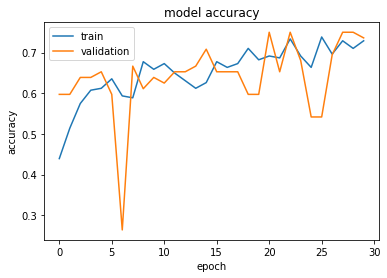

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

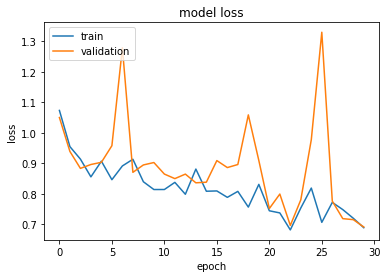

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()